In [4]:
source_path = "../"
device = 'cuda:0'

import os
import sys
import shutil
import csv
import numpy as np
import math
import json
import pickle
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

import gc
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import optuna

sys.path.append(source_path + 'model')
from utils import amino_acid_to_number, tokenize, Tee
from functions import get_A2N_list, tokenize, make_train_val_test_lists_rand, prepare_data
from models import make_predictions, ProtDataset, Transformer_2k, LinearModel

/apps/pytorch/2.2.0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def ED(tensor1, tensor2):
    """
    Calculate the pairwise Euclidean distance between rows of two tensors.
    
    Parameters:
    tensor1: torch.Tensor
        The first tensor.
    tensor2: torch.Tensor
        The second tensor.
        
    Returns:
    torch.Tensor
        The pairwise Euclidean distances between rows of the two tensors.
    """
    # Calculate the element-wise squared difference
    squared_diff = (tensor1.unsqueeze(1) - tensor2.unsqueeze(0)).pow(2)
    
    # Sum along the feature axis and take the square root
    distances = squared_diff.sum(dim=-1).sqrt()
    
    return distances

In [6]:
datafile = pd.read_csv("../Data/Data_prepared/Somermeyer2022_4GFP.csv")

phenotypes, seqs, seqs1h = prepare_data(datafile)
n, L, AA_size = seqs1h.shape

seqs1hf = seqs1h.reshape(-1, AA_size*L)
seqs1hf = seqs1hf.to(device).float()

seqs_ex = seqs + AA_size*torch.tensor(range(L))
X = seqs_ex.to(device)
y = phenotypes.to(device)

In [7]:
genes = ['amacGFP', 'avGFP', 'cgreGFP', 'ppluGFP']

### Figure 6A PCA

In [8]:
from sklearn.decomposition import PCA
sub = random.sample(range(len(datafile)), 2000)
pca = PCA(n_components=2) 
embedded_points = pca.fit_transform(seqs1hf[sub].cpu().numpy())

In [9]:
sub = np.where(datafile.hd < 100)[0]
embeds_all = pca.transform(seqs1hf[sub].cpu().numpy())

In [8]:
embeds_all = embeds_all/10

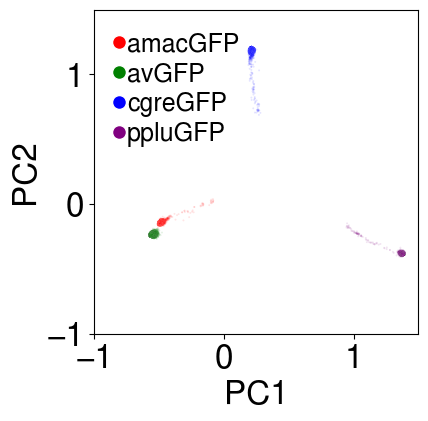

In [9]:
import seaborn as sns

plt.rcParams.update({'font.size': 24})
plt.rcParams['font.family'] =  'Nimbus Sans'

palette = {'amacGFP': 'r', 'avGFP': 'g', 'cgreGFP': 'b', 'ppluGFP': 'purple'}
sns.scatterplot(x=embeds_all.T[0], y=embeds_all.T[1], s=2, alpha=.1, hue=datafile.iloc[sub].gene, palette=palette, rasterized=True)

palette = {0: 'r', 1: 'g', 2: 'b', 3: 'purple'}
legend_labels = genes
legend_points = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[i], markersize=10) for i in range(4)]
plt.legend(legend_points, legend_labels, loc='upper left', fontsize=18, 
           handlelength=.2, handletextpad=0.2, labelspacing=.2, frameon=False)
plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel('PC1')
plt.ylabel('PC2')

plt.xlim(-1, 1.5)
plt.ylim(-1, 1.5)

plt.tight_layout(pad=1.0)

plt.savefig("../figures/GFP_PCA.pdf", transparent=True)

plt.show()

### Raw mutational effects

/scratch/local/45262713/ipykernel_316299/796880335.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.1)  # Adjust the pad value as needed
/scratch/local/45262713/ipykernel_316299/796880335.py:40: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0.1)  # Adjust the pad value as needed


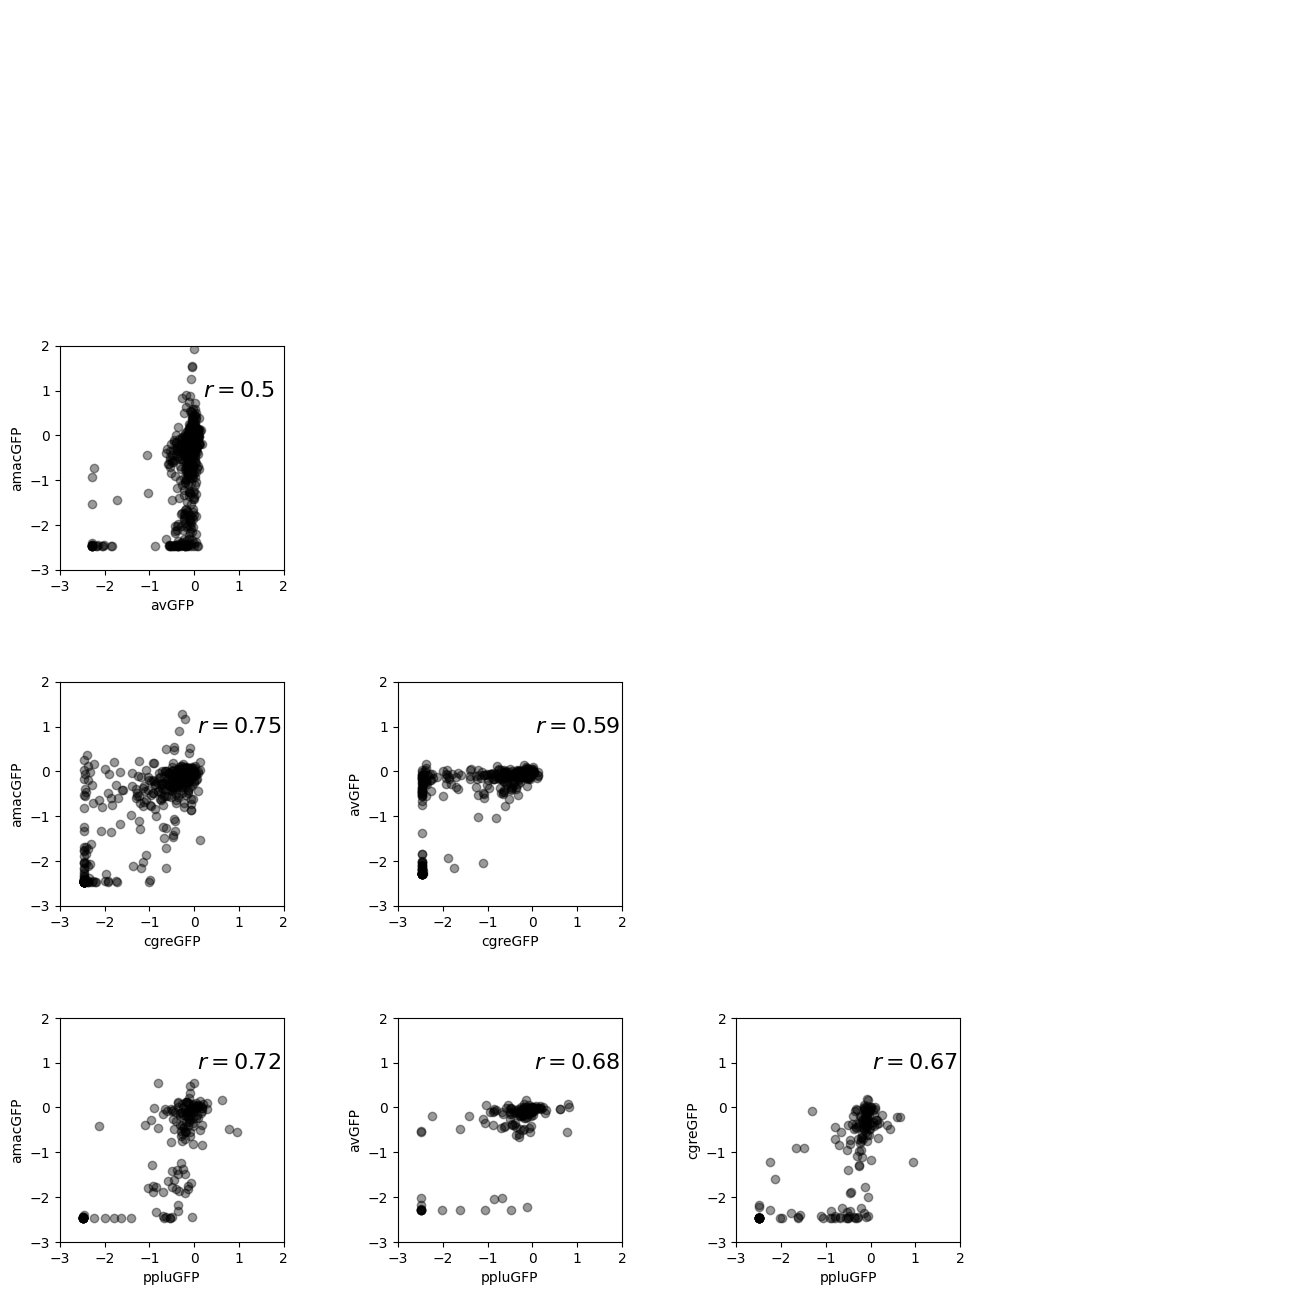

In [8]:
fig, axes = plt.subplots(4, 4, figsize=(16, 16), constrained_layout=True, 
                        gridspec_kw={'hspace': 0.5, 'wspace': 0.5})


for i in range(4):
    for j in range(4):
        if j >= i: 
            axes[i,j].yaxis.set_visible(False)
            axes[i,j].xaxis.set_visible(False)
            axes[i,j].spines['left'].set_visible(False)
            axes[i,j].spines['right'].set_visible(False)
            axes[i,j].spines['top'].set_visible(False)
            axes[i,j].spines['bottom'].set_visible(False)
        else: 
            gene1 = genes[i]
            gene2 = genes[j]

            datasub1 = datafile[datafile.gene == gene1]
            datasub2 = datafile[datafile.gene == gene2]

            datasub1.set_index('mut', inplace=True)
            datasub2.set_index('mut', inplace=True)

            datam = pd.merge(datasub1, datasub2, left_index=True, right_index=True)

            sub = [":"  not in mut for mut in datam.index]

            mut_effects1 = datam[sub]['DMS_score_x'] - datam[sub]['DMS_score_x']['wt']
            mut_effects2 = datam[sub]['DMS_score_y'] - datam[sub]['DMS_score_y']['wt']

            axes[i,j].scatter(mut_effects1, mut_effects2, c='black', alpha=.4)            
            axes[i,j].set_xlim(-3, 2)
            axes[i,j].set_ylim(-3, 2)
            axes[i,j].set_xlabel(gene1)
            axes[i,j].set_ylabel(gene2)
            axes[i,j].set_aspect('equal')
            r = pearsonr(mut_effects1, mut_effects2)[0]
            r = np.round(r, 2)
            axes[i,j].text(1, 1, f'$r = ${r}', ha='center', va='center', fontsize=16)
plt.tight_layout(pad=0.1)  # Adjust the pad value as needed
plt.show()            

### Figure 6B Fitted mutational effects

In [9]:
def split_list(list_to_split, ratio):
    length_total = len(list_to_split)
    length_part1 = int(length_total * ratio)
    length_part2 = length_total - length_part1
    random.shuffle(list_to_split)
    part1 = list_to_split[:length_part1]
    part2 = list_to_split[length_part1:]
    return part1, part2

In [10]:
def get_dataloader(sub_list, train_list, val_list, test_list, train_dataset=False):
    X = seqs1h[sub_list].float().to(device)
    y = phenotypes[sub_list].to(device)

    X_train, y_train = X[train_list], y[train_list]
    X_val, y_val = X[val_list], y[val_list]
    X_test, y_test = X[test_list], y[test_list]

    train_dataset = ProtDataset(X_train, y_train)
    train_loader = data.DataLoader(train_dataset,
                                   batch_size=1000,
                                   shuffle=True,
                                   drop_last=False)

    val_dataset = ProtDataset(X_val, y_val)
    val_loader = data.DataLoader(val_dataset,
                                batch_size=1000,
                                shuffle=False,
                                drop_last=False)

    test_dataset = ProtDataset(X_test, y_test)
    test_loader = data.DataLoader(test_dataset,
                                batch_size=1000,
                                shuffle=False,
                                drop_last=False)    
    if train_dataset: 
        return train_loader, val_loader, test_loader, train_dataset
    else: return train_loader, val_loader, test_loader

In [20]:
import copy

def train_model(model0, train_loader, val_loader, test_loader, n_epochs, lda):
    model = copy.deepcopy(model0)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    r2_test_log = []
    for epoch in range(n_epochs):
            model.train()
            total_loss = 0
            for batch_inputs, batch_targets in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_inputs)
                loss = criterion(outputs, batch_targets) + lda*model.state_dict()['fc.weight'][0].abs().sum()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            if epoch % 10 == 0:
                print(f"Epoch {epoch+1}/{n_epochs}, Loss: {total_loss/len(train_loader)}")
                model.eval()
                pred, true = make_predictions(model, val_loader)
                print(pearsonr(pred, true)[0]**2)

    model.eval()
    pred, true = make_predictions(model, test_loader)
    criterion = pearsonr(pred, true)[0]**2  
    print(f"Test $r2$ = {criterion}")
    
    return model

In [12]:
def gauge_fix_add(weights):
    wts = weights.copy()
    for i in range(L):
        s = wts[i*AA_size:(i + 1)*AA_size].sum()
        wts[i*AA_size: (i + 1)*AA_size] = wts[i*AA_size: (i + 1)*AA_size] - s/AA_size
    return wts.flatten()

#### Train on all data

In [13]:
dropout_p = 0.0
fc_out_norm = True
n_epochs = 100
# lda = .01
learning_rate = .1

In [21]:
# sub_list = list(np.where(datafile.gene == gene)[0])
sub_list = random.sample(range(n), 50000)
train_list = random.sample(range(len(sub_list)), 20000)
comp_list = list(set(range(len(sub_list))).difference(train_list))
test_val_list = random.sample(comp_list, 10000)
test_list, val_list = split_list(test_val_list, .5)

train_loader, val_loader, test_loader, _ = get_dataloader(sub_list, train_list, val_list, test_list)

In [22]:
model = LinearModel(L, AA_size, dropout_p, fc_out_norm).to(device)
model_all = train_model(model, train_loader, val_loader, test_loader, n_epochs, lda=0.)

Epoch 1/100, Loss: 1.0463608473539352
0.000735331040893056
Epoch 11/100, Loss: 0.9542211621999741
0.08876508064601918
Epoch 21/100, Loss: 0.24083698987960817
0.6541518804931395
Epoch 31/100, Loss: 0.19203669875860213
0.6941184507696538
Epoch 41/100, Loss: 0.19853814020752908
0.6981556617333206
Epoch 51/100, Loss: 0.18126020953059196
0.7111897179966401
Epoch 61/100, Loss: 0.19750668928027154
0.6672990769464383
Epoch 71/100, Loss: 0.18427080437541007
0.7183539854195549
Epoch 81/100, Loss: 0.1697675071656704
0.7187127356251227
Epoch 91/100, Loss: 0.18202304616570472
0.692100674112234
Test $r2$ = 0.7141085049141168


In [23]:
models_gene = {}

In [26]:
for gene in genes: 
    sub_list = list(np.where(datafile.gene == gene)[0])
    train_list = random.sample(range(len(sub_list)), int(.8 * len(sub_list)))
    print(len(train_list))
    comp_list = list(set(range(len(sub_list))).difference(train_list))
    test_val_list = random.sample(comp_list, min(10000, len(comp_list)))
    test_list, val_list = split_list(test_val_list, .5)
    train_loader, val_loader, test_loader, _ = get_dataloader(sub_list, train_list, val_list, test_list)
    
    model = copy.deepcopy(model_all)
    for name, param in model.named_parameters():
        if name not in ['fc.weight', "fc.bias"]:
            param.requires_grad = False
    
    model_trained = train_model(model, train_loader, val_loader, test_loader, n_epochs, lda=.01)
    models_gene[gene] = model_trained

28400
Epoch 1/100, Loss: 158.6151096738618
0.3455669297592082
Epoch 11/100, Loss: 162.01482785981278
0.4372597576198947
Epoch 21/100, Loss: 165.77735848262392
0.3551853617434272
Epoch 31/100, Loss: 171.8792777225889
0.794455331979877
Epoch 41/100, Loss: 178.45739325161637
0.7983678122250707
Epoch 51/100, Loss: 183.18403678104795
0.7318521475977798
Epoch 61/100, Loss: 188.22536494814116
0.7894807371727762
Epoch 71/100, Loss: 194.0560444798963
0.8242787843126066
Epoch 81/100, Loss: 199.6103973388672
0.7327737876145313
Epoch 91/100, Loss: 204.9010283371498
0.7234173319927109
Test $r2$ = 0.8320583911075329
43220
Epoch 1/100, Loss: 158.11898942427203
0.43118922088176886
Epoch 11/100, Loss: 168.7935686978427
0.8681601643319709
Epoch 21/100, Loss: 182.60689301924273
0.8313664639010883
Epoch 31/100, Loss: 195.36837976629084
0.8575976116745141
Epoch 41/100, Loss: 206.91671094027433
0.8852260382110106
Epoch 51/100, Loss: 218.20417369495738
0.8760723519801907
Epoch 61/100, Loss: 229.1868979714133

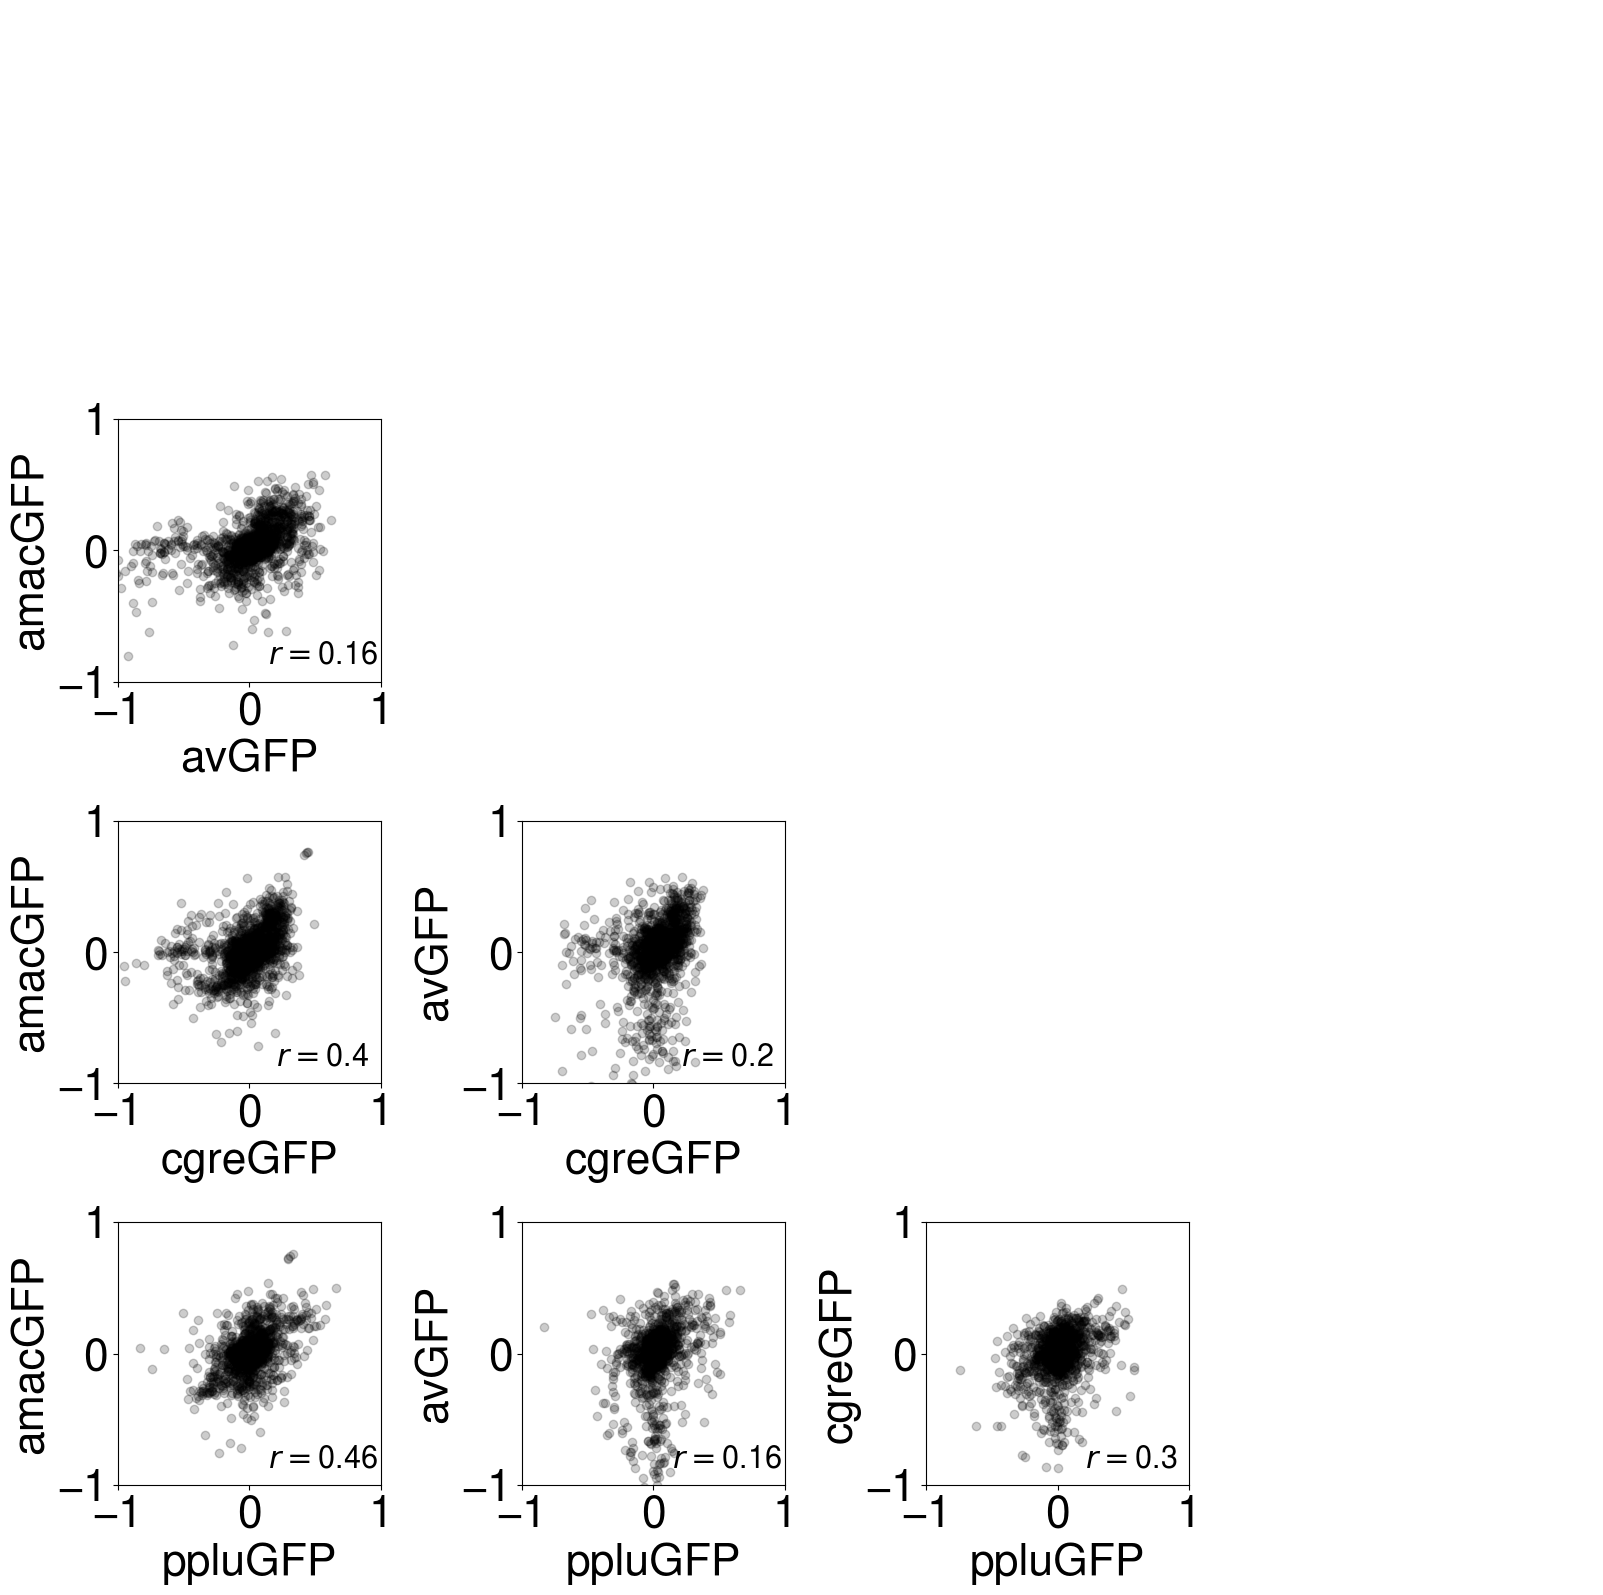

In [27]:
plt.rcParams.update({'font.size': 32})
plt.rcParams['font.family'] =  'Nimbus Sans'


fig, axes = plt.subplots(4, 4, figsize=(16, 16), layout='tight')


for i in range(4):
    for j in range(4):
        if j >= i: 
            axes[i,j].yaxis.set_visible(False)
            axes[i,j].xaxis.set_visible(False)
            axes[i,j].spines['left'].set_visible(False)
            axes[i,j].spines['right'].set_visible(False)
            axes[i,j].spines['top'].set_visible(False)
            axes[i,j].spines['bottom'].set_visible(False)
        else: 
            gene1 = genes[i]
            gene2 = genes[j]

            sub_list1 = list(np.where(datafile.gene == gene1)[0])
            sub_list2 = list(np.where(datafile.gene == gene2)[0])
            presence = (seqs1hf[sub_list1].sum(0) != 0.) * (seqs1hf[sub_list2].sum(0) != 0.)
            presence = presence.detach().cpu().numpy()
            pos_shared = np.where(presence)[0]            
            
            mut_effects1 = models_gene[gene1].state_dict()['fc.weight'].flatten().detach().cpu().numpy()
            mut_effects1 = gauge_fix_add(mut_effects1)/50
            mut_effects2 = models_gene[gene2].state_dict()['fc.weight'].flatten().detach().cpu().numpy()
            mut_effects2 = gauge_fix_add(mut_effects2)/50

            axes[i,j].scatter(mut_effects1[pos_shared], mut_effects2[pos_shared], c='black', alpha=.2)            
            axes[i,j].set_xlim(-1, 1)
            axes[i,j].set_ylim(-1, 1)
            axes[i,j].set_xlabel(gene1)
            axes[i,j].set_ylabel(gene2)
            axes[i,j].set_aspect('equal')
            r = pearsonr(mut_effects1[pos_shared], mut_effects2[pos_shared])[0]
            r = np.round(r, 2)
            axes[i,j].text(.78, .1, f'$r = ${r}', ha='center', va='center', fontsize=22, transform=axes[i,j].transAxes)
plt.tight_layout(pad=0.2, w_pad= .5)  # Adjust the pad value as needed
plt.savefig("../figures/GFP_mut_scatter.pdf", transparent=True)
plt.show()

### Figure 6D Cross protein prediction

In [12]:
import os
def get_files(directory, substring):
    files_with_substring = []
    for filename in os.listdir(directory):
        if substring in filename:
            files_with_substring.append(filename)
    return files_with_substring

In [13]:
genes = ['amacGFP', 'avGFP', 'cgreGFP', 'ppluGFP']

In [18]:
results_path = "/blue/juannanzhou/palash.sethi/Projects/ProteinLLEs/ProteinLLE_v7/output/"

dirs = get_files(results_path, "focal") # Get all directories

paths = {gene:[] for gene in genes}

for d in dirs:
    if os.path.exists(results_path + d + "/done"):
        if int(d[-1]) > 5:
            with open(results_path + d + "/train_list.pkl", 'rb') as file:
                train_list = pickle.load(file)
            gene_counts = datafile.iloc[train_list].gene.value_counts()
            if len(gene_counts) == 4:
                gene = gene_counts.sort_values().index[-1]
            else: gene = list(set(genes).difference(gene_counts.index))[0]
            paths[gene].append(os.path.join(results_path, d) + "/")

In [19]:
# Make predictions on test genotypes for different genes and calculate R^2 values

results_by_gene = {gene: [] for gene in genes}

for gene in genes:
    for out_path in paths[gene]:
        
        with open(out_path + "train_list.pkl", 'rb') as file:
            train_list = pickle.load(file)
        
        try: 
            with open(out_path + "val_list.pkl", 'rb') as file:
                val_list = pickle.load(file)
            
        except: val_list = []

        r_results = {}
        for g in genes:
            r_list = {}
            sub_list = np.where(datafile.gene == g)[0]
            comp_list = set(sub_list).difference(train_list + val_list)
            comp_list = list(comp_list)
            test_list = random.sample(comp_list, min(10000, len(comp_list)))
            X_test, y_test = X[test_list], y[test_list]
            test_dataset = ProtDataset(X_test, y_test)
            test_loader = data.DataLoader(test_dataset,
                                        batch_size=500,
                                        shuffle=False,
                                        drop_last=False)

            for model_name  in ["TF_1_BestModel", "TF_2_BestModel", "TF_3_BestModel"]:
                model_best = torch.load(out_path + model_name)
                model_best.eval()
                pred, true = make_predictions(model_best, test_loader)
                r = pearsonr(pred, true)[0]**2
                r_list[model_name] = r

            for model_name in ["Linear_BestModel"]:
                X__ = seqs1h.float().to(device)
                X_test, y_test = X__[test_list], y[test_list]
                test_dataset = ProtDataset(X_test, y_test)
                test_loader = data.DataLoader(test_dataset,
                                            batch_size=500,
                                            shuffle=False,
                                            drop_last=False)

                model_best = torch.load(out_path + model_name)
                pred, true = make_predictions(model_best, test_loader)
                r = pearsonr(pred, true)[0]**2
                r_list[model_name] = r

            r_results[g] = r_list

        results_by_gene[gene].append(r_results)

In [22]:
model_names = ["Linear_BestModel", "TF_1_BestModel", "TF_2_BestModel", "TF_3_BestModel"]

In [23]:
means_by_gene = {}
stds_by_gene = {}


for gene in genes:
    results = results_by_gene[gene]
    nrep = len(results)
    means = {}
    stds = {}
    for g in genes:
        ms_by_model = {}    
        ss_by_model = {}
        for model_name in model_names:
            rs = [results[i][g][model_name] for i in range(nrep)]
            ms_by_model[model_name] = np.mean(rs)
            ss_by_model[model_name] = np.std(rs)
        means[g] = ms_by_model
        stds[g] = ss_by_model
    means_by_gene[gene] = means
    stds_by_gene[gene] = stds    

In [24]:
models = ["Linear", "Pairwise", "4-way", "8-way"]
colors = ['gray', '#377eb8',  '#dede00', 'orange']
colors = ['gray', '#377eb8',  '#4daf4a', 'orange']

In [115]:
def get_r_stat(df, norm=None):
    df_ = df.copy()
    df__ = df.copy()
    for i in range(4): #REMOVE
        df_.iloc[:, i] = df_.iloc[:, :i + 1].max(1) # REMOVE
    for m in [1, 2, 3]:
        diffs = (df_.iloc[:, m].to_numpy() - df_.iloc[:, m - 1].to_numpy())
        res_r2 = (1 - df_.iloc[:, 0].to_numpy())
        epi_r2 = (df_.iloc[:, -1].to_numpy() - df_.iloc[:, 0].to_numpy())
        res_8_r2 = (1 - df.max(1))
        if norm == 'res':
            df__.iloc[:, m] = diffs/res_r2
        elif norm == 'epi':
            df__.iloc[:, m] = diffs/epi_r2
        else: 
            df__.iloc[:, m] = diffs
    df__[df__ < 0] = 0
    
    return df__

In [26]:
means_by_gene = {}
stds_by_gene = {}
epi_r2_by_gene = {}

for gene in genes:
    results = results_by_gene[gene]
    nrep = len(results)
    means = {}
    stds = {}
    epi_r2_by_gene[gene] = {}
    for g in genes:
        df = pd.DataFrame({i: results[i][g] for i in range(len(results))}).T
        df = df[['Linear_BestModel', 'TF_1_BestModel', 'TF_2_BestModel', 'TF_3_BestModel']]
        df_delta = get_r_stat(df, norm='epi')
        means[g] = df_delta.mean()
        stds[g] = df_delta.std()
        epi_r2  = (df.iloc[:, -1] - df.iloc[:, 0]).mean()    
        epi_r2_by_gene[gene][g] = epi_r2
        
    means_by_gene[gene] = means
    stds_by_gene[gene] = stds

In [27]:
models = ["Linear", "Pairwise", "4-way", "8-way"]
colors = ['gray', '#377eb8',  'orange', '#4daf4a', ]

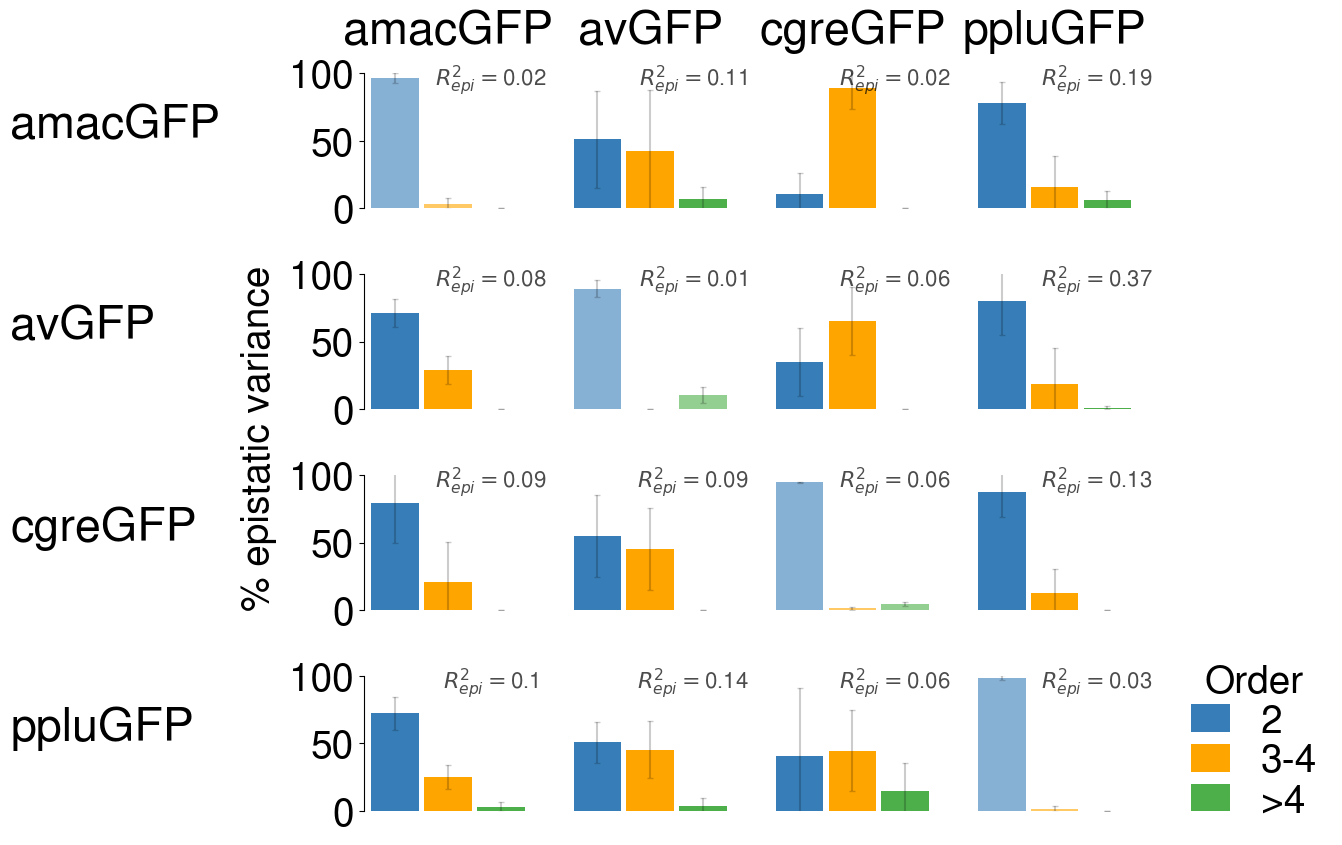

In [29]:
plt.rcParams.update({'font.size': 28})
plt.rcParams['font.family'] =  'Nimbus Sans'


fig, axes = plt.subplots(4, 4, figsize=(10, 10))
plt.subplots_adjust(wspace=0.2, hspace=.2)
legs = {'Pairwise': '2', '4-th order': '3-4', '8-th order': ">4"}

for i in range(4):
    for j in range(4):

            axes[i,j].xaxis.set_visible(False)
            if j != 0:
                axes[i,j].yaxis.set_visible(False)     
                axes[i,j].spines['left'].set_visible(False)
            axes[i,j].spines['right'].set_visible(False)
            axes[i,j].spines['top'].set_visible(False)
            axes[i,j].spines['bottom'].set_visible(False)
            
            # axes[i,j].spines['bottom'].set_visible(False)
            
            gene = genes[i]
            g = genes[j]
            values = means_by_gene[gene][g].iloc[1:]
            errors = stds_by_gene[gene][g].iloc[1:]
            epi_r2 = epi_r2_by_gene[gene][g]
            epi_r2 = np.round(epi_r2, 2)
            
            if i == j:
                alpha = .6
            else: alpha = 1

            axes[i,j].bar(models[1:], 100*values, yerr=100*errors, capsize=2, color=colors[1:], error_kw={'alpha': 0.2},
                          width=.9, alpha=alpha, label = legs.values())
            axes[i,j].set_xticks([])
            
            axes[i,j].set_ylim(0., 100)            
            axes[i,j].set_yticks([0., 50, 100])    
            

            axes[i,j].set_box_aspect(.8)
            
            if i==j==0:
                axes[i,j].text(1.8, 95, 
                               "$R^2_{epi} = $" + f"{epi_r2}", 
                               fontsize=16, 
                               ha='center', 
                               va='center', 
                               color='black', 
                               alpha=.7)
            else:
                axes[i,j].text(1.8, 95, 
                               "$R^2_{epi} = $" + f"{epi_r2}", 
                               fontsize=16, 
                               ha='center', 
                               va='center', 
                               color='black', 
                               alpha=.7)
                
            
            if (i==2) & (j==3):
                legend = axes[i,j].legend(loc='upper left', 
                                 bbox_to_anchor=(1.1, -.14),
                                 frameon=False, 
                                 labelspacing=0.1, 
                                 handlelength=1.0)

                legend.set_title("Order")


for j, label in enumerate(genes):
    axes[0, j].annotate(label, xy=(0.5, 1.2), xytext=(0, 2),
                       xycoords='axes fraction', textcoords='offset points',
                       size='large', ha='center', va='baseline')

for j, label in enumerate(genes):
    axes[j, 0].annotate(label, xy=(-2.1, 0.5), xytext=(0, 2),
                       xycoords='axes fraction', textcoords='offset points',
                       size='large', ha='left', va='baseline')


fig.text(0.02, 0.5, '% epistatic variance', va='center', ha='center', rotation='vertical')

plt.savefig("../figures/cross_protein_v2.pdf", bbox_inches='tight', transparent=True)        
plt.show()


### Supplemental Figure 7

In [7]:
paths = ["/blue/juannanzhou/palash.sethi/Projects/ProteinLLEs/ProteinLLE_v7/output/Somermeyer2022_4GFP_Random_10.0%_rep_1/"]

In [8]:
out_path = paths[0]

In [39]:
with open(out_path + "train_list.pkl", 'rb') as file:
    train_list = pickle.load(file)

try: 
    with open(out_path + "val_list.pkl", 'rb') as file:
        val_list = pickle.load(file)
        val_list = list(val_list)

except: val_list = []

In [40]:
sub_list = np.arange(n)
comp_list = set(sub_list).difference(train_list + val_list)
comp_list = list(comp_list)

#### Fit linear model

In [98]:
X = seqs1h.float().to(device)
y = phenotypes.to(device)

X_train, y_train = X[train_list], y[train_list]
X_val, y_val = X[val_list], y[val_list]
X_test, y_test = X[test_list], y[test_list]

train_dataset = ProtDataset(X_train, y_train)
train_loader = data.DataLoader(train_dataset,
                               batch_size=1000,
                               shuffle=True,
                               drop_last=False)

val_dataset = ProtDataset(X_val, y_val)
val_loader = data.DataLoader(val_dataset,
                            batch_size=1000,
                            shuffle=False,
                            drop_last=False)

In [99]:
learning_rate = .01
dropout_p = 0.
fc_out_norm = True
lin_model = LinearModel(L, AA_size, dropout_p, fc_out_norm).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(lin_model.parameters(), lr=learning_rate)

In [100]:
n_epochs = 200
for epoch in range(n_epochs):
        lin_model.train()
        total_loss = 0
        for batch_inputs, batch_targets in train_loader:
            optimizer.zero_grad()
            outputs = lin_model(batch_inputs)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {total_loss/len(train_loader)}")
            lin_model.eval()
            pred, true = make_predictions(lin_model, val_loader)
            print(pearsonr(pred, true)[0]**2)

lin_model.eval()
pred, true = make_predictions(lin_model, val_loader)

Epoch 1/200, Loss: 1.0808869685445512
0.0007906333487666631
Epoch 11/200, Loss: 0.987056872674397
0.00025387640998087444
Epoch 21/200, Loss: 0.9895328666482653
0.00040891402402850447
Epoch 31/200, Loss: 0.297588763492448
0.5316537568192352
Epoch 41/200, Loss: 0.18868559492485865
0.6687857829391433
Epoch 51/200, Loss: 0.17541019299200603
0.6589944450196383
Epoch 61/200, Loss: 0.16213887078421457
0.6691799273839895
Epoch 71/200, Loss: 0.1606356150337628
0.666122114107912
Epoch 81/200, Loss: 0.1534077035529273
0.6682346474283597
Epoch 91/200, Loss: 0.15166960656642914
0.6827750611676298
Epoch 101/200, Loss: 0.16084715404680797
0.6586216313281764
Epoch 111/200, Loss: 0.1457858681678772
0.6889991502175042
Epoch 121/200, Loss: 0.1417118167238576
0.6947792939305588
Epoch 131/200, Loss: 0.14338275364467076
0.6903323551201986
Epoch 141/200, Loss: 0.1454345796789442
0.6769546917937929
Epoch 151/200, Loss: 0.14805346940244948
0.6779730352961028
Epoch 161/200, Loss: 0.18141232218061173
0.624557602

In [101]:
r2_reps = {}

for rep in range(3):
    test_list = random.sample(comp_list, 5000)

    X_test, y_test = X[test_list], y[test_list]
    test_dataset = ProtDataset(X_test, y_test)
    test_loader = data.DataLoader(test_dataset,
                                batch_size=500,
                                shuffle=False,
                                drop_last=False)


    r_list = {}

    model_name = 'Linear_BestModel'

    X__ = seqs1h.float().to(device)
    X_test, y_test = X__[test_list], y[test_list]
    test_dataset = ProtDataset(X_test, y_test)
    test_loader = data.DataLoader(test_dataset,
                                batch_size=500,
                                shuffle=False,
                                drop_last=False)

    pred, true = make_predictions(lin_model, test_loader)
    r = pearsonr(pred, true)[0]**2
    r_list[model_name] = r
    
    r2_reps[rep] = r_list

#### Replicate test

In [103]:
seqs1hf = seqs1h.reshape(-1, AA_size*L)
seqs1hf = seqs1hf.to(device).float()

seqs_ex = seqs + AA_size*torch.tensor(range(L))
X = seqs_ex.to(device)
y = phenotypes.to(device)

In [104]:
for rep in range(3):
    test_list = random.sample(comp_list, 5000)

    X_test, y_test = X[test_list], y[test_list]
    test_dataset = ProtDataset(X_test, y_test)
    test_loader = data.DataLoader(test_dataset,
                                batch_size=500,
                                shuffle=False,
                                drop_last=False)


    r_list = {}

    for model_name  in ["TF_1_BestModel", "TF_2_BestModel", "TF_3_BestModel"]:
        print(model_name)
        model_best = torch.load(out_path + model_name)
        model_best.eval()
        pred, true = make_predictions(model_best, test_loader)
        r = pearsonr(pred, true)[0]**2
        r_list[model_name] = r
    
    r2_reps[rep].update(r_list)


TF_1_BestModel
TF_2_BestModel
TF_3_BestModel
TF_1_BestModel
TF_2_BestModel
TF_3_BestModel
TF_1_BestModel
TF_2_BestModel
TF_3_BestModel


In [106]:
r2_reps = pd.DataFrame(r2_reps).T

In [107]:
delta_rs = {}

In [108]:
delta_rs['Pairwise'] = r2_reps['TF_1_BestModel'] - r2_reps['Linear_BestModel']
delta_rs['4-th order'] = r2_reps['TF_2_BestModel'] - r2_reps['TF_1_BestModel']
delta_rs['8-th order'] = r2_reps['TF_3_BestModel'] - r2_reps['TF_2_BestModel']

In [109]:
delta_rs = pd.DataFrame(delta_rs)

In [110]:
plt.rcParams.update({'font.size': 28})
plt.rcParams['font.family'] =  'Nimbus Sans'

In [111]:
df = r2_reps
df = df[['Linear_BestModel', 'TF_1_BestModel', 'TF_2_BestModel', 'TF_3_BestModel']]
df_delta = get_r_stat(df, norm='epi')
means = df_delta.mean()
stds = df_delta.std()
epi_r2  = (df.iloc[:, -1] - df.iloc[:, 0]).mean()    
epi_r2_by_gene[gene][g] = epi_r2

In [9]:
plt.bar(models[1:], 100*means[1:], yerr=100*stds[1:], capsize=2, color=colors[1:],
              width=.9, label = models[1:])

plt.ylim(0, 100)
plt.ylabel('% epistatic variance')
plt.xlabel('Order')
plt.xticks(ticks=range(3), labels=["2", "3-4", "5-8"])
plt.text(1.8, 90, 
       "$R^2_{epi} = $" + f"{np.round(epi_r2, 2)}", 
       fontsize=24, 
       ha='center', 
       va='center', 
       color='black', 
       alpha=.7)

plt.savefig("../figures/GFP_Random.pdf", bbox_inches='tight', transparent=True)        

### Figure 6C Distance predictions

#### Rep within prediction

In [34]:
import torch.utils.data as data

In [35]:
results_paths = ["/blue/juannanzhou/palash.sethi/Projects/ProteinLLEs/ProteinLLE_v4/output/Somermeyer2022_4GFP_HD2_10000.0%_rep_1/"]
# results_paths = ["/blue/juannanzhou/palash.sethi/Projects/ProteinLLEs/ProteinLLE_v7/output/Somermeyer2022_4GFP_HD4_10000.0%_rep_1/"]
nrep = len(results_paths)

r2_by_d_model_rep = {}
preds_rep = {}

for i in range(nrep):
    results_path = results_paths[i]
    with open(results_path + "train_list.pkl", 'rb') as file:
        train_list = pickle.load(file)

    comp_list = set(np.where(datafile.hd < 20)[0]).difference(train_list)
    comp_list = list(comp_list)
    test_list = comp_list
    X_test, y_test = X[test_list], y[test_list]
    test_dataset = ProtDataset(X_test, y_test)
    test_loader = data.DataLoader(test_dataset,
                                batch_size=500,
                                shuffle=False,
                                drop_last=False)
    preds = {}
    for model_name  in ["TF_1_BestModel", "TF_2_BestModel", "TF_3_BestModel"]:
    # for model_name  in ["TF_1_BestModel"]:    
        print(model_name)
        model_best = torch.load(results_path + model_name)
        model_best.eval()
        pred, _ = make_predictions(model_best, test_loader)
        preds[model_name] = pred

    for model_name in ["Linear_BestModel"]:
        X__ = seqs1h.float().to(device)
        X_test, y_test = X__[test_list], y[test_list]
        test_dataset = ProtDataset(X_test, y_test)
        test_loader = data.DataLoader(test_dataset,
                                    batch_size=500,
                                    shuffle=False,
                                    drop_last=False)

        model_best = torch.load(results_path + model_name)
        pred, true = make_predictions(model_best, test_loader)
        preds[model_name] = pred
    
    preds_rep[i] = preds

TF_1_BestModel
TF_2_BestModel
TF_3_BestModel


In [36]:
distances = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10])
nrep = 10

for i in range(nrep):
    random.seed(i)
    r2_by_d_model = {}
    for model_name in ["Linear_BestModel", "TF_1_BestModel", "TF_2_BestModel", "TF_3_BestModel"]:
    # for model_name  in ["TF_1_BestModel"]:        
        r2_by_d = {}
        for d in distances:
            pos = np.where(datafile.iloc[comp_list].hd == d)[0]
            # pos = np.where((datafile.iloc[comp_list].hd) % 2 == d)[0]
            pos = random.sample(list(pos), int(.9*(len(pos))))
            r2_by_d[d] = pearsonr(preds_rep[0][model_name][pos], true[pos])[0]**2
            
        r2_by_d_model[model_name] = r2_by_d
    
    r2_by_d_model_rep[i] = r2_by_d_model

r2sHD_sum = {}

for k in [0, 1, 2, 3]:
    dat = pd.DataFrame([list(r2_by_d_model_rep[i].values())[k] for i in range(2)])
    r2sHD_sum[k] = pd.DataFrame({"mean": dat.mean(), "std": dat.std()})

#### Plot

In [37]:
models = ['Linear_BestModel', 'TF_1_BestModel', 'TF_2_BestModel', 'TF_3_BestModel']

nrep = 10

colors = ['gray', '#377eb8',  '#4daf4a', 'orange']

dist_chosen = distances

In [38]:
def get_r_stat(df, norm=None):
    df_ = df.copy()
    df__ = df.copy()
    for i in range(4): #REMOVE
        df_.iloc[:, i] = df_.iloc[:, :i + 1].max(1) # REMOVE
    for m in [1, 2, 3]:
        diffs = (df_.iloc[:, m].to_numpy() - df_.iloc[:, m - 1].to_numpy())
        res_r2 = (1 - df_.iloc[:, 0].to_numpy())
        epi_r2 = (df_.iloc[:, -1].to_numpy() - df_.iloc[:, 0].to_numpy())
        res_8_r2 = (1 - df.max(1))
        if norm == 'res':
            df__.iloc[:, m] = diffs/res_r2
        elif norm == 'epi':
            df__.iloc[:, m] = diffs/epi_r2
        else: 
            df__.iloc[:, m] = diffs
    df__[df__ < 0] = 0
    
    return df__

In [39]:
plotdat_add = pd.DataFrame({i: pd.Series(r2_by_d_model_rep[i]['Linear_BestModel']) for i in range(nrep)})

In [40]:
plotdat_epi = pd.DataFrame({i: pd.DataFrame(r2_by_d_model_rep[i]).max(1) for i in range(nrep)})

In [41]:
diffs_by_rep = {}

for i in range(nrep):
    df = pd.DataFrame(r2_by_d_model_rep[i])
    diffs_by_rep[i] = get_r_stat(df, norm='epi')

plotdata = {model_id:{} for model_id in [1, 2, 3]}

for model_id in [1, 2, 3]:
    df = pd.DataFrame({i: diffs_by_rep[i].iloc[:, model_id] for i in range(nrep)})
    values = df.mean(1)[dist_chosen]
    errors = df.std(1)[dist_chosen]
    plotdata[model_id] = {'values': values, 'errors': errors}


/scratch/local/45008360/ipykernel_4100579/564805587.py:14: RuntimeWarning: invalid value encountered in divide
  df__.iloc[:, m] = diffs/epi_r2
/scratch/local/45008360/ipykernel_4100579/564805587.py:14: RuntimeWarning: invalid value encountered in divide
  df__.iloc[:, m] = diffs/epi_r2
/scratch/local/45008360/ipykernel_4100579/564805587.py:14: RuntimeWarning: invalid value encountered in divide
  df__.iloc[:, m] = diffs/epi_r2
/scratch/local/45008360/ipykernel_4100579/564805587.py:14: RuntimeWarning: invalid value encountered in divide
  df__.iloc[:, m] = diffs/epi_r2
/scratch/local/45008360/ipykernel_4100579/564805587.py:14: RuntimeWarning: invalid value encountered in divide
  df__.iloc[:, m] = diffs/epi_r2
/scratch/local/45008360/ipykernel_4100579/564805587.py:14: RuntimeWarning: invalid value encountered in divide
  df__.iloc[:, m] = diffs/epi_r2


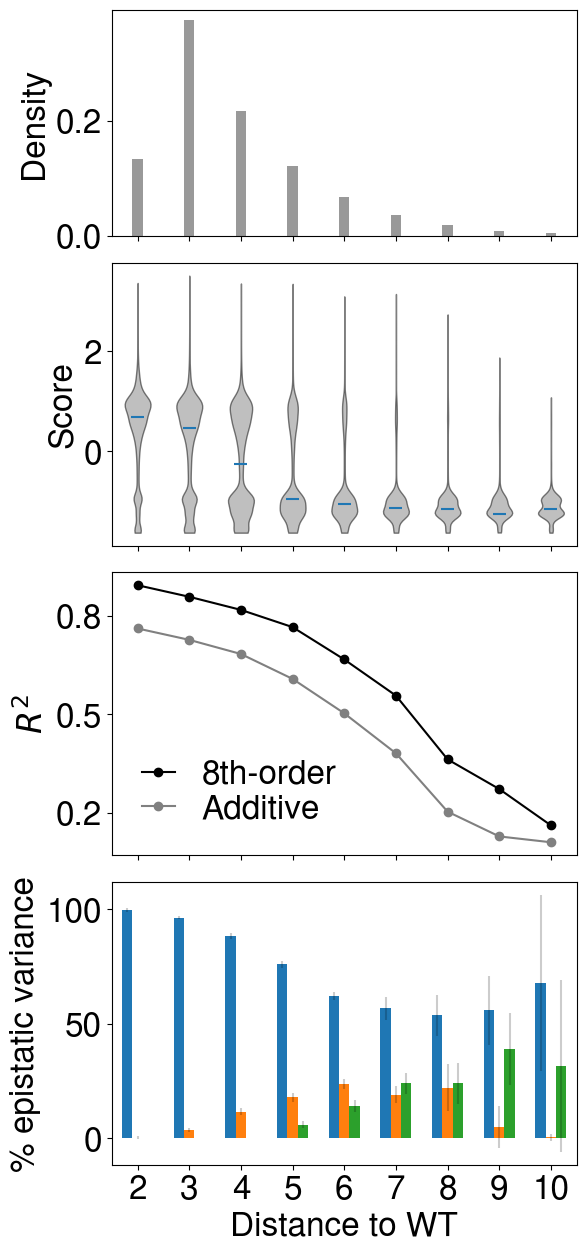

In [42]:
plt.rcParams.update({'font.size': 24})
plt.rcParams['font.family'] =  'Nimbus Sans'
fig, axs = plt.subplots(4, 1, figsize=(6, 15), width_ratios = [1], 
                        height_ratios = [.8, 1, 1, 1], gridspec_kw={'hspace': 0.1, 'wspace': .5},
                       sharex=True)

positions = dist_chosen 
bar_width = .2

axs[2].plot(dist_chosen, 
               plotdat_epi.mean(1), 
               color='black', label='8th-order', 
               marker='o', linestyle='-')
axs[2].plot(dist_chosen, 
               plotdat_add.mean(1), 
               color='gray', label='Additive', 
               marker='o', linestyle='-')


# axs[2].plot(plotdat.index[plotdat.index <= dist_chosen.max()], 
#              plotdat.mean(1)[plotdat.index <= dist_chosen.max()], color='black', alpha=.6)
axs[2].set_yticks([0.2, .5, .8])
axs[2].set_ylabel("$R^2$")
legend = axs[2].legend(loc='lower left', 
                      bbox_to_anchor=(0, 0), 
                      frameon=False, 
                      labelspacing=0.1, 
                      handlelength=1.0
                     )


# Plot bars with error bars
for i, cls in enumerate(plotdata.keys()):
    values = 100*plotdata[cls]['values']  # get values for the class
    errors = 100*plotdata[cls]['errors']  # get errors for the class
    axs[3].bar([p + (i - 1) * bar_width for p in positions], values, width=bar_width, label=cls, yerr=errors, capsize=0, error_kw={'alpha': 0.2})

axs[3].set_ylabel('% epistatic variance')
axs[3].set_xlim(distances[0] - .5, distances[-1] + .5)
axs[3].set_yticks([0, 50, 100])
# axs[0].set_xticks(dist_chosen)
# axs[0].tick_params(axis='x', top=False, bottom=True, labelbottom=True)

bins = np.arange(len(datafile.iloc[comp_list].hd.unique()) + 1) - 0.5
axs[0].hist(list(datafile.iloc[comp_list].hd), bins=bins, align='mid', 
            rwidth=0.2, color='gray', alpha=.8, density=True)
axs[0].set_xticks(distances)
axs[0].set_ylabel('Density')
# axs[1].set_xticks(dist_chosen)
# axs[1].tick_params(axis='x', top=False, bottom=True, labelbottom=True)

data = {d: datafile[datafile.hd == d]['DMS_score'] for d in [1] + list(distances)}
data = [data[key] for key in data]
# parts = axs[2].boxplot(data)

parts = axs[1].violinplot(data, showmeans=False, showmedians=True, showextrema=False)
for pc in parts['bodies']:
    pc.set_facecolor('gray')
    pc.set_edgecolor('black')
    pc.set_alpha(.5)
axs[1].set_ylabel('Score')

axs[3].set_xlabel('Distance to WT')
axs[3].set_xticks([y + 2 for y in range(len(distances))],
              labels=distances)

plt.show()

In [91]:
fig.savefig("../figures/GFP-MSA-HD_v2.pdf", bbox_inches='tight')